<a href="https://colab.research.google.com/github/fadouaamri/Human_face_generator/blob/main/FaceGenerator2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

#◘acces to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [7]:
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "/content/drive/MyDrive/test/celeba_gann/data.zip"
#download the zip file
gdown.download(url, output, quiet=True)
#extract file
with ZipFile("/content/drive/MyDrive/test/celeba_gann/data.zip", "r") as zipobj:
    zipobj.extractall("/content/drive/MyDrive/test/celeba_gann")

In [13]:
#Resize images into (64,64)
#preprocessing
dataset = keras.utils.image_dataset_from_directory("/content/drive/MyDrive/test/celeba_gann", label_mode=None, image_size=(64, 64), batch_size=32)
#normalization
dataset = dataset.map(lambda x: x / 255.0)


Found 9765 files belonging to 1 classes.


In [14]:
dataset

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [15]:
##########discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

In [16]:
#generator
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0 

In [17]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [18]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("/content/drive/MyDrive/test/celeba_gann/generated_images/generated_img_%03d_%d.png" % (epoch, i))

In [19]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)




In [20]:
#training
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])


Epoch 1/100
306/306 [==============================] - 101s 299ms/step - d_loss: 0.4493 - g_loss: 1.5154
Epoch 2/100
306/306 [==============================] - 92s 299ms/step - d_loss: 0.5324 - g_loss: 1.4421
Epoch 3/100
306/306 [==============================] - 92s 300ms/step - d_loss: 0.5810 - g_loss: 1.3531
Epoch 4/100
306/306 [==============================] - 92s 298ms/step - d_loss: 0.5164 - g_loss: 1.8135
Epoch 5/100
306/306 [==============================] - 92s 300ms/step - d_loss: 0.6301 - g_loss: 1.1217
Epoch 6/100
306/306 [==============================] - 92s 300ms/step - d_loss: 0.6252 - g_loss: 1.1264
Epoch 7/100
306/306 [==============================] - 92s 299ms/step - d_loss: 0.5818 - g_loss: 1.1696
Epoch 8/100
306/306 [==============================] - 92s 299ms/step - d_loss: 0.6043 - g_loss: 1.2944
Epoch 9/100
306/306 [==============================] - 92s 300ms/step - d_loss: 0.6415 - g_loss: 1.3038
Epoch 10/100
306/306 [==============================] - 92s 299

In [24]:
import cv2
import os
import matplotlib.pyplot as plt

In [26]:
Gen_images = "/content/drive/MyDrive/test/celeba_gann/generated_images"
len(os.listdir(Gen_images))

1000

In [29]:
images=[]
for filename in os.listdir(Gen_images)[990:]:
  #read image
  img= cv2.imread(os.path.join(Gen_images,filename))
  images.append(img)

<Figure size 1000x1000 with 0 Axes>

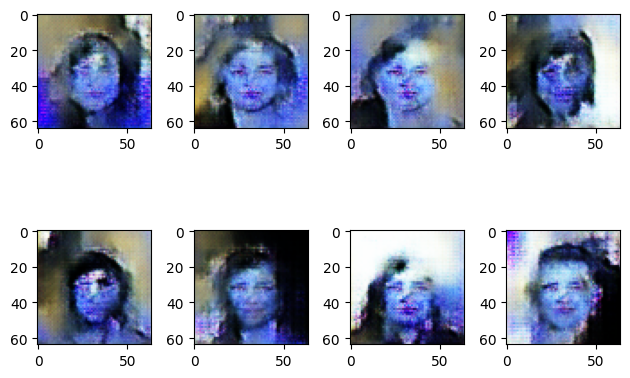

In [34]:

#data visualization
#generated images
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,4)

index=0

for i in range(2):
    for j in range(4):

            ax[i,j].imshow(images[index].reshape(64,64,3))


            index+=1

plt.tight_layout()
plt.show()

In [31]:
import joblib

# save model with joblib
filename = "/content/drive/MyDrive/test/Completed_model.joblib"

joblib.dump(gan, filename)